In [74]:
import numpy as np 
import pandas as pd 
df = pd.read_csv('./data/timeseries/weather.csv')
df.shape

(52696, 22)

In [8]:
import torch
from tqdm import *
train_len, val_len, test_len = 36600, 4982, 10253
data = torch.rand(train_len, 96, 21)
drop_out = 0.3

random_matrix = torch.ones(train_len, 96, 21)
# random_matrix = torch.zeros(self.data['x'], config.seq_len, enc_in)
for i in trange(train_len):
    mask = torch.rand(96, 21)
    mask[mask <= drop_out] = 0
    random_matrix[i] = mask
data = data * random_matrix
data.nonzero().shape, 36600 * 96 * 21

100%|██████████| 36600/36600 [00:00<00:00, 56640.01it/s]


(torch.Size([51648271, 3]), 73785600)

In [ ]:
import gzip
import pandas as pd

def read_ushcn_file(path: str) -> pd.DataFrame:
    records = []
    with gzip.open(path, 'rt') as f:
        for line in f:
            if not line.strip():
                continue
            station_id = line[0:6].strip()
            element = int(line[6:7])
            year = int(line[7:11])

            values, flags = {}, {}
            for i in range(13):  # 12个月 + 年值
                start_val = 12 + i * 7
                end_val = start_val + 5
                val_str = line[start_val:end_val].strip()
                flag_str = line[end_val:end_val+1].strip()

                val = None if val_str in ["", "-9999"] else int(val_str)
                flag = flag_str if flag_str else None

                if i < 12:
                    values[f"VALUE{i+1}"] = val
                    flags[f"FLAG{i+1}"] = flag
                else:
                    values["VALUE13"] = val
                    flags["FLAG13"] = flag

            records.append({
                "STATION_ID": station_id,
                "ELEMENT": element,
                "YEAR": year,
                **values,
                **flags
            })
    return pd.DataFrame(records)

# 示例
df = read_ushcn_file("./data/iregular/USHCN/ushcn_v2_monthly/9641C_201112_F52.pcp.gz")
df

In [ ]:
df.head()

In [ ]:
import torch 
data = torch.load('data/iregular/USHCN/ushcn.pt', map_location='cpu', weights_only=True)
len(data[0])

In [ ]:
data[0][0], data[0][1].shape, data[0][2].shape, data[0][3].shape

In [ ]:
for i in range(len(data)):
    print(f"Sample {i}:")
    print(f"  Time indices shape: {data[i][0]}")
    print(f"  Node indices shape: {data[i][1].shape}")
    # print(f"  Static features shape: {data[i][2].shape}")
    # print(f"  Mask shape: {data[i][3].shape}")   

In [ ]:
import argparse
parser = argparse.ArgumentParser('IMTS Forecasting')

parser.add_argument('--state', type=str, default='def')
parser.add_argument('-n',  type=int, default=int(1e8), help="Size of the dataset")
parser.add_argument('--hop', type=int, default=1, help="hops in GNN")
parser.add_argument('--nhead', type=int, default=1, help="heads in Transformer")
parser.add_argument('--tf_layer', type=int, default=1, help="# of layer in Transformer")
parser.add_argument('--nlayer', type=int, default=1, help="# of layer in TSmodel")
parser.add_argument('--epoch', type=int, default=1000, help="training epoches")
parser.add_argument('--patience', type=int, default=10, help="patience for early stop")
parser.add_argument('--history', type=int, default=24, help="number of hours (months for ushcn and ms for activity) as historical window")
parser.add_argument('-ps', '--patch_size', type=float, default=24, help="window size for a patch")
parser.add_argument('--stride', type=float, default=24, help="period stride for patch sliding")
parser.add_argument('--logmode', type=str, default="a", help='File mode of logging.')

parser.add_argument('--lr',  type=float, default=1e-3, help="Starting learning rate.")
parser.add_argument('--w_decay', type=float, default=0.0, help="weight decay.")
parser.add_argument('-b', '--batch_size', type=int, default=32)

parser.add_argument('--save', type=str, default='experiments/', help="Path for save checkpoints")
parser.add_argument('--load', type=str, default=None, help="ID of the experiment to load for evaluation. If None, run a new experiment.")
parser.add_argument('--seed', type=int, default=1, help="Random seed")
parser.add_argument('--dataset', type=str, default='physionet', help="Dataset to load. Available: physionet, mimic, ushcn")

# value 0 means using original time granularity, Value 1 means quantization by 1 hour, 
# value 0.1 means quantization by 0.1 hour = 6 min, value 0.016 means quantization by 0.016 hour = 1 min
parser.add_argument('--quantization', type=float, default=0.0, help="Quantization on the physionet dataset.")
parser.add_argument('--model', type=str, default='tPatchGNN', help="Model name")
parser.add_argument('--outlayer', type=str, default='Linear', help="Model name")
parser.add_argument('-hd', '--hid_dim', type=int, default=64, help="Number of units per hidden layer")
parser.add_argument('-td', '--te_dim', type=int, default=10, help="Number of units for time encoding")
parser.add_argument('-nd', '--node_dim', type=int, default=10, help="Number of units for node vectors")
parser.add_argument('--gpu', type=str, default='0', help='which gpu to use.')

args = parser.parse_args([])

In [ ]:
args.n_months = 48 # 48 monthes
args.pred_window = 1 # predict future one month

def USHCN_time_chunk(data, args, device):

	chunk_data = []

	for b, (record_id, tt, vals, mask) in enumerate(data):
		for st in range(0, args.n_months - args.history - args.pred_window + 1, args.pred_window):
			et = st + args.history + args.pred_window
			if(et == args.n_months):
				indices = torch.where((tt >= st) & (tt <= et))[0]
			else:
				indices = torch.where((tt >= st) & (tt < et))[0]
			t_bias = torch.tensor(st).to(device)
			chunk_data.append((record_id, tt[indices]-t_bias, vals[indices], mask[indices], t_bias))

	return chunk_data

In [ ]:
chunk_data = USHCN_time_chunk(data, args, device='cpu')

In [ ]:
len(chunk_data)

In [ ]:
len(chunk_data[0])

In [ ]:
chunk_data[0][1]

In [ ]:
chunk_data[2][1]

In [ ]:
chunk_data[5][2]

In [70]:
import pandas as pd 

df = pd.read_csv('data/iregular/USHCN/small_chunked_sporadic.csv')
df.keys()

Index(['ID', 'Time', 'Value_0', 'Value_1', 'Value_2', 'Value_3', 'Value_4',
       'Mask_0', 'Mask_1', 'Mask_2', 'Mask_3', 'Mask_4'],
      dtype='object')

In [73]:
df.groupby(level=0)

In [18]:
!pip install torchdiffeq
!pip install --pre deepchem

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [19]:
import torch
import torch.nn as nn

from torchdiffeq import odeint
import math
import numpy as np

import deepchem as dc
import matplotlib.pyplot as plt

In [20]:
def f(t,z):
    return t

z0 = torch.Tensor([0])
t = torch.linspace(0,2,100)
out = odeint(f, z0, t);

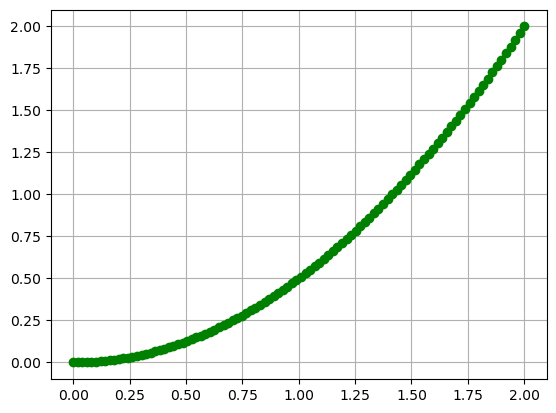

In [21]:
plt.plot(t, out, 'go--')
plt.grid()
plt.show()

In [ ]:
from torchdiffeq import odeint_adjoint as odeadj

class f(nn.Module):
    def __init__(self, dim):
        super(f, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim,124),
            nn.ReLU(),
            nn.Linear(124,124),
            nn.ReLU(),
            nn.Linear(124,dim),
            nn.Tanh()
        )

    def forward(self, t, x):
        return self.model(x)


class ODEBlock(nn.Module):
  
  # This is ODEBlock. Think of it as a wrapper over ODE Solver , so as to easily connect it with our neurons !

    def __init__(self, f):
        super(ODEBlock, self).__init__()
        self.f = f
        self.integration_time = torch.Tensor([0,1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        out = odeadj(
            self.f,
            x,
            self.integration_time
        )

        return out[1]



class ODENet(nn.Module):
  
  #This is our main neural network that uses ODEBlock within a sequential module

    def __init__(self, in_dim, mid_dim, out_dim):
        super(ODENet, self).__init__()
        fx = f(dim=mid_dim)
        self.fc1 = nn.Linear(in_dim, mid_dim)
        self.relu1 = nn.ReLU(inplace=True)
        self.norm1 = nn.BatchNorm1d(mid_dim)
        self.ode_block = ODEBlock(fx)
        self.dropout = nn.Dropout(0.4)
        self.norm2 = nn.BatchNorm1d(mid_dim)
        self.fc2 = nn.Linear(mid_dim, out_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        out = self.fc1(x)
        out = self.relu1(out)
        out = self.norm1(out)
        out = self.ode_block(out)
        out = self.norm2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

    
model = ODENet(in_dim=1024, mid_dim=1000, out_dim=1)

In [5]:
preds = ['192-168-89-160-9100_node-disk-writes-completed-total'
 'adservice_container-memory-usage-bytes'
 'cartservice_container-memory-cache'
 'productcatalogservice_container-memory-failures-total'
 'redis_container-cpu-usage-seconds-total']
label = 'productcatalogservice'

label in preds

False

In [7]:
has_substring = any(label in s for s in preds)
print(f"是否存在包含 '{label}' 子串的元素？{has_substring}")


是否存在包含 'productcatalogservice' 子串的元素？True


In [9]:
# 定义基础数据（可根据实际场景替换为你的真实数据）
preds = [
    'recommendationservice_container-memory-rss',
    'paymentservice_istio-latency-99',
    'emailservice_container-memory-rss',
    'productcatalogservice-bytes-90',
    'shippingservice_container-memory-failures-total'
]
service_label = 'productcatalogservice'  # 原 label，统一变量名更清晰

# 初始化 Topk 统计计数器
top1_cnt = 0
top2_cnt = 0
top3_cnt = 0
top4_cnt = 0
top5_cnt = 0

# 核心逻辑：遍历每个预测结果（root_cause 即当前遍历的 preds 元素）
for root_cause in preds:  # 假设 preds 是多个 root_cause 结果的集合，若单个 root_cause 可直接使用
    # 判断 service_label 是否作为子串存在于 root_cause 的前 k 个元素中
    # （注：若 root_cause 是列表/数组，root_cause[:k] 取前 k 个元素；若 root_cause 是字符串，[:k] 取前 k 个字符，根据你的场景调整）
    
    # Top1：判断前 1 个元素中是否包含子串
    if any(service_label in item for item in root_cause[:1]):
        top1_cnt += 1
    
    # Top2：判断前 2 个元素中是否包含子串
    if any(service_label in item for item in root_cause[:2]):
        top2_cnt += 1
    
    # Top3：判断前 3 个元素中是否包含子串
    if any(service_label in item for item in root_cause[:3]):
        top3_cnt += 1
    
    # Top4：判断前 4 个元素中是否包含子串
    if any(service_label in item for item in root_cause[:4]):
        top4_cnt += 1
    
    # Top5：判断前 5 个元素中是否包含子串
    if any(service_label in item for item in root_cause[:5]):
        top5_cnt += 1

# 计算 Topk 正确率（假设总样本数为 len(preds)，可根据实际样本数调整）
total_samples = len(preds)
top1_acc = top1_cnt / total_samples if total_samples > 0 else 0.0
top2_acc = top2_cnt / total_samples if total_samples > 0 else 0.0
top3_acc = top3_cnt / total_samples if total_samples > 0 else 0.0
top4_acc = top4_cnt / total_samples if total_samples > 0 else 0.0
top5_acc = top5_cnt / total_samples if total_samples > 0 else 0.0

# 输出结果
print(f"目标子串：{service_label}")
print(f"总样本数：{total_samples}")
print(f"Top1 命中次数：{top1_cnt}，正确率：{top1_acc:.4f}")
print(f"Top2 命中次数：{top2_cnt}，正确率：{top2_acc:.4f}")
print(f"Top3 命中次数：{top3_cnt}，正确率：{top3_acc:.4f}")
print(f"Top4 命中次数：{top4_cnt}，正确率：{top4_acc:.4f}")
print(f"Top5 命中次数：{top5_cnt}，正确率：{top5_acc:.4f}")

目标子串：productcatalogservice
总样本数：5
Top1 命中次数：0，正确率：0.0000
Top2 命中次数：0，正确率：0.0000
Top3 命中次数：0，正确率：0.0000
Top4 命中次数：0，正确率：0.0000
Top5 命中次数：0，正确率：0.0000
